### Statistics on Apparent Geocentric Position of Sun

In [1]:
import common
from datetime import date, timedelta

# Generate the data for every day starting from 2000-01-01.
FIRST_DATE = date(2000, 1, 1)
dates = [FIRST_DATE + timedelta(days=i) for i in range(0, 365 * 20)]

# Compute the sun longitude for each date. 
# Simply assume `fraction` is 0.0 (which means we are calculating the longitude of the moment 00:00:00 of the date).
jdes = [common.ut1_to_jde(d.year, d.month, d.day, 0.0) for d in dates]

sun_coords = [common.sun_apparent_geocentric_coord(jde) for jde in jdes]

sun_longitudes = [sun_coord.lon for sun_coord in sun_coords]

In [2]:
# Put the data into a dataframe.
assert len(dates) == len(sun_longitudes)

import pandas as pd
df = pd.DataFrame({
  'date': dates,
  'sun_longitude': sun_longitudes
})

df['date'] = pd.to_datetime(df['date'])

df

,date,sun_longitude
0,2000-01-01,279.859210
1,2000-01-02,280.878644
2,2000-01-03,281.898165
3,2000-01-04,282.917752
4,2000-01-05,283.937381
...,...,...
7295,2019-12-22,269.816484
7296,2019-12-23,270.835268
7297,2019-12-24,271.854252
7298,2019-12-25,272.873406


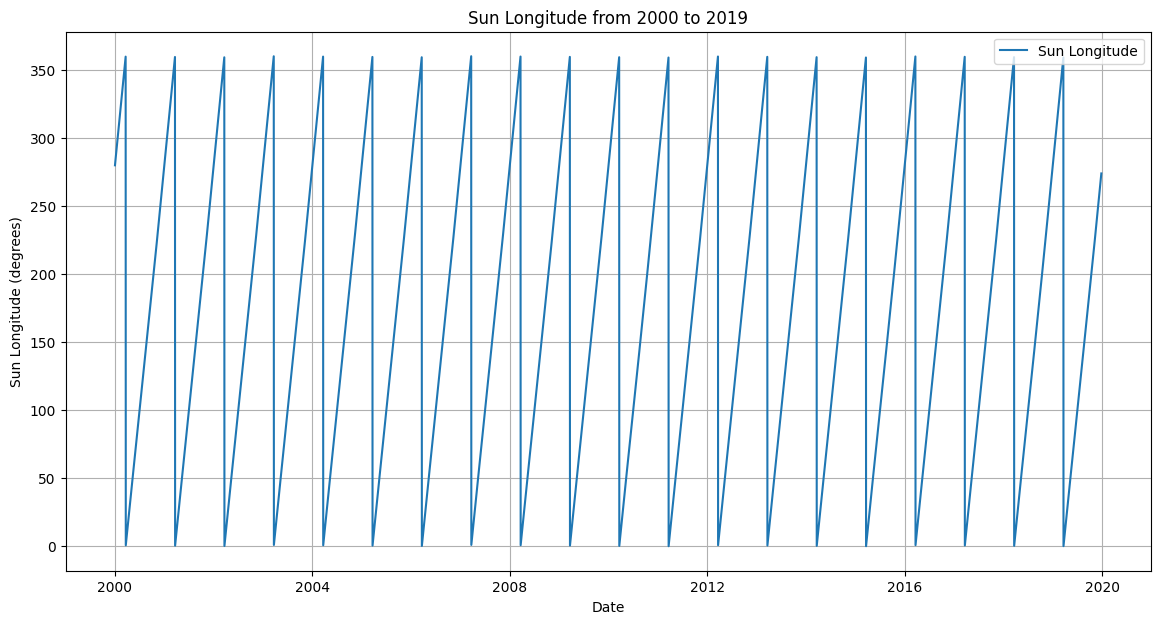

In [3]:
# Plot the data.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['sun_longitude'], label='Sun Longitude')
plt.xlabel('Date')
plt.ylabel('Sun Longitude (degrees)')
plt.title('Sun Longitude from 2000 to 2019')
plt.legend()
plt.grid(True)
plt.show()

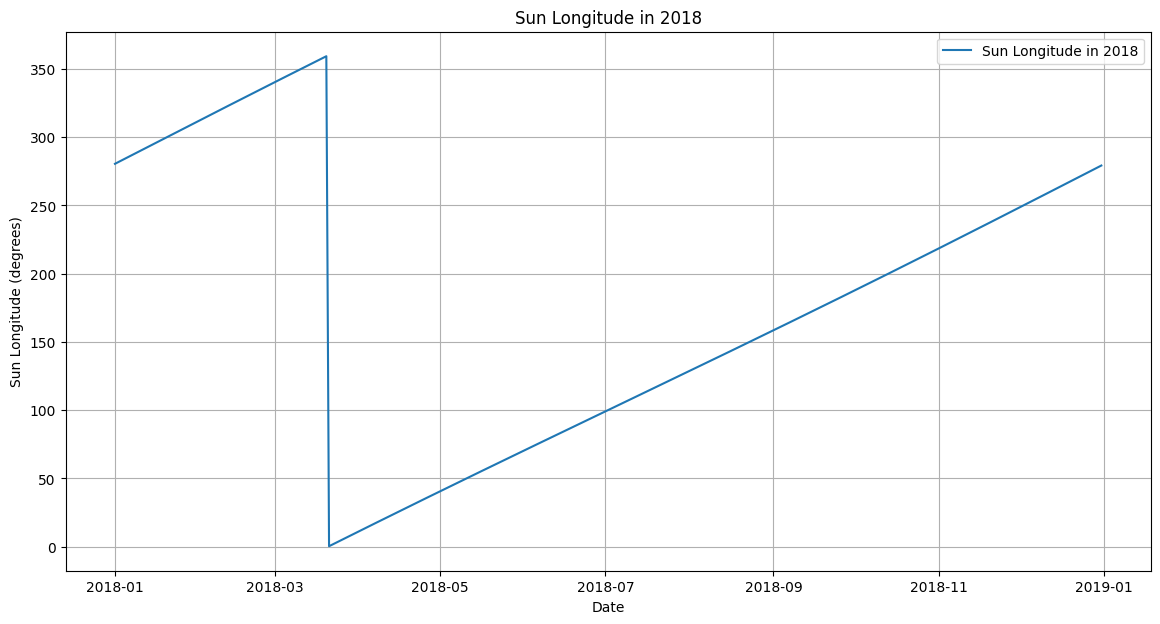

In [4]:
# Show data in year 2018.
df_2018 = df[df['date'].dt.year == 2018]

plt.figure(figsize=(14, 7))
plt.plot(df_2018['date'], df_2018['sun_longitude'], label='Sun Longitude in 2018')
plt.xlabel('Date')
plt.ylabel('Sun Longitude (degrees)')
plt.title('Sun Longitude in 2018')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# In order to smoothly use Newton's method, we need to make the data monotonic.
# The Sun's longitude drastically drops from 359.99999999999999 to 0.0 at around Spring Equinox.

df_2018_modified = df_2018.copy()

# Figure out the data points before 2018-04-01 and whose longitudes >= 200.0.
# And modify these data points' longitudes to (original_value - 360.0).
for index, row in df_2018_modified.iterrows():
  if row['date'].date() < date(2018, 4, 1) and row['sun_longitude'] >= 200.0:
    df_2018_modified.at[index, 'sun_longitude'] = row['sun_longitude'] - 360.0


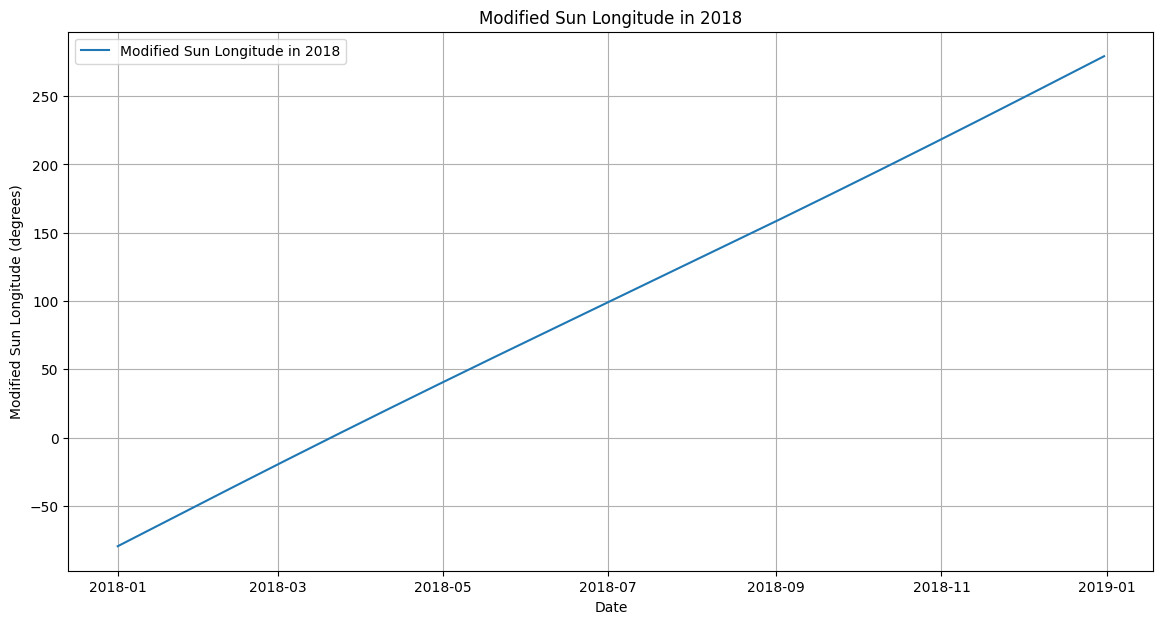

In [6]:
# Plot the modified data.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_2018_modified['date'], df_2018_modified['sun_longitude'], label='Modified Sun Longitude in 2018')
plt.xlabel('Date')
plt.ylabel('Modified Sun Longitude (degrees)')
plt.title('Modified Sun Longitude in 2018')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def start_jde(year: int) -> float:
  '''Calculate the Julian Ephemeris Day Number (JDE) at the beginning of the year.'''
  return common.ut1_to_jde(year, 1, 1, 0.0)

def start_lon(year: int) -> float:
  '''Calculate the Solar longitude at the beginning of the year.'''
  return common.sun_apparent_geocentric_coord(start_jde(year)).lon

def end_jde(year: int) -> float:
  '''Calculate the Julian Ephemeris Day Number (JDE) at the end of the year.'''
  return common.ut1_to_jde(year + 1, 1, 1, 0.0)

def end_lon(year: int) -> float:
  '''Calculate the Solar longitude at the end of the year.'''
  return common.sun_apparent_geocentric_coord(end_jde(year)).lon

def discriminant(year: int, expected_lon: float) -> int:
  '''Return the count of the roots of the equation `f(jde) = 0.0`.'''
  slon, elon = start_lon(year), end_lon(year)
  root_count: int = 0

  if slon <= expected_lon < 360:
    root_count += 1
  if 0 <= expected_lon < elon:
    root_count += 1

  return root_count


In [8]:
two_roots_years:  dict[int, float] = dict()
zero_roots_years: dict[int, float] = dict()

for year in range(1900, 2034):
  slon, elon = start_lon(year), end_lon(year)
  if slon == elon:
    assert False, 'There should be no years where the start and end longitude are the same.'

  if slon < elon:
    assert 2 == discriminant(year, slon), f'{year} has {discriminant(year, slon)} roots.'
    two_roots_years[year] = slon - elon

  if slon > elon:
    assert 0 == discriminant(year, elon), f'{year} has {discriminant(year, elon)} roots.'
    zero_roots_years[year] = slon - elon

max_gap_two_roots_year: int = max(two_roots_years, key=lambda k: abs(two_roots_years[k]))
max_gap_zero_roots_year: int = max(zero_roots_years, key=lambda k: abs(zero_roots_years[k]))

Plot year 1932, start lon: 279.36039781893624, end lon: 280.1415505148695.


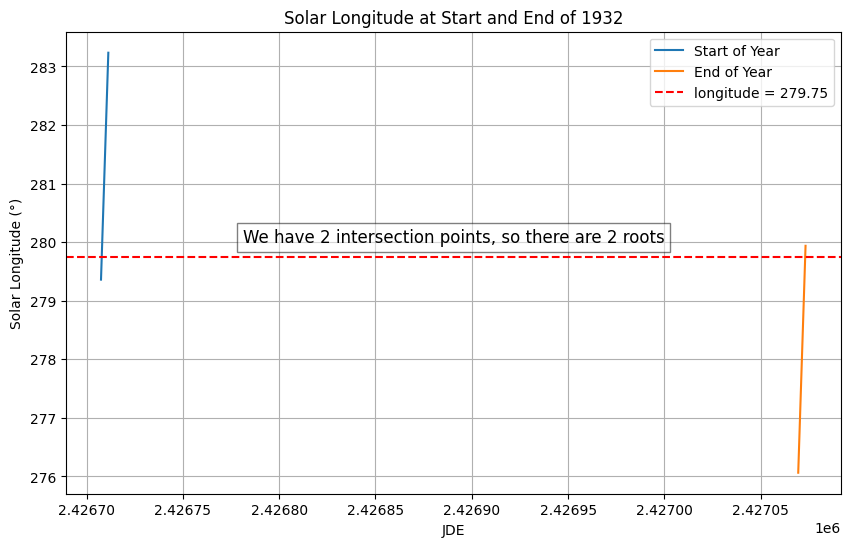

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot year with the specified start and end longitudes
print(f'Plot year {max_gap_two_roots_year}, start lon: {start_lon(max_gap_two_roots_year)}, end lon: {end_lon(max_gap_two_roots_year)}.')

# Compute JDE for start and end of the year
sjde = common.ut1_to_jde(max_gap_two_roots_year, 1, 1, 0.0)
ejde = common.ut1_to_jde(max_gap_two_roots_year + 1, 1, 1, 0.0)

# Create data points for the start and end of the year
jdes_start = [sjde + 0.2 * i for i in range(0, 20)]
jdes_end = [ejde - 0.2 * i for i in range(20, 0, -1)]

# Compute solar longitudes
lons_start = [common.sun_apparent_geocentric_coord(jde).lon for jde in jdes_start]
lons_end = [common.sun_apparent_geocentric_coord(jde).lon for jde in jdes_end]

# Combine into dataframes
df_start = pd.DataFrame({'jde': jdes_start, 'lon': lons_start})
df_end = pd.DataFrame({'jde': jdes_end, 'lon': lons_end})

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_start['jde'], df_start['lon'], label='Start of Year')
plt.plot(df_end['jde'], df_end['lon'], label='End of Year')

# Add the horizontal line for longitude = 279.75
plt.axhline(y=279.75, color='r', linestyle='--', label='longitude = 279.75')
plt.text(x=(sjde + ejde) / 2, y=280, s='We have 2 intersection points, so there are 2 roots',
         horizontalalignment='center', color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel('JDE')
plt.ylabel('Solar Longitude (°)')
plt.title(f'Solar Longitude at Start and End of {max_gap_two_roots_year}')
plt.legend()
plt.grid(True)
plt.show()

Plot year 1901, start lon: 279.9090772471962, end lon: 279.65339100920926.


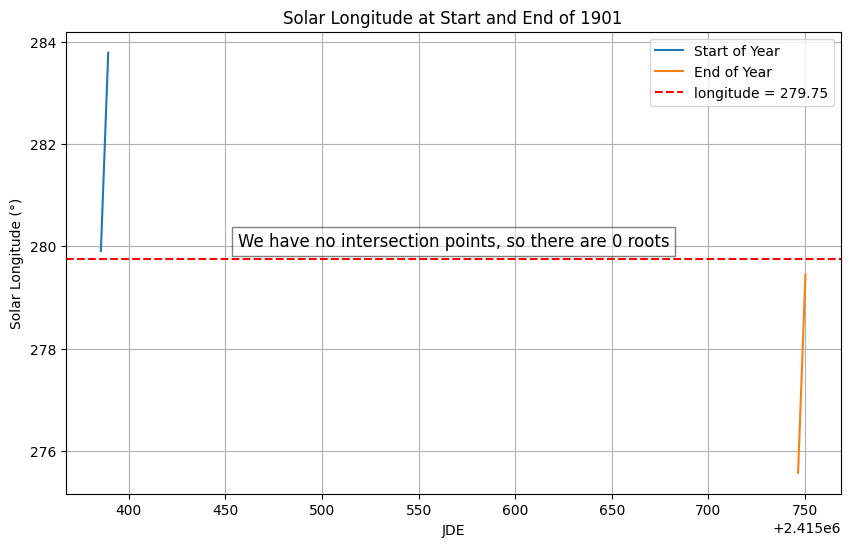

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot year with the specified start and end longitudes
print(f'Plot year {max_gap_zero_roots_year}, start lon: {start_lon(max_gap_zero_roots_year)}, end lon: {end_lon(max_gap_zero_roots_year)}.')

# Compute JDE for start and end of the year
sjde = common.ut1_to_jde(max_gap_zero_roots_year, 1, 1, 0.0)
ejde = common.ut1_to_jde(max_gap_zero_roots_year + 1, 1, 1, 0.0)

# Create data points for the start and end of the year
jdes_start = [sjde + 0.2 * i for i in range(0, 20)]
jdes_end = [ejde - 0.2 * i for i in range(20, 0, -1)]

# Compute solar longitudes
lons_start = [common.sun_apparent_geocentric_coord(jde).lon for jde in jdes_start]
lons_end = [common.sun_apparent_geocentric_coord(jde).lon for jde in jdes_end]

# Combine into dataframes
df_start = pd.DataFrame({'jde': jdes_start, 'lon': lons_start})
df_end = pd.DataFrame({'jde': jdes_end, 'lon': lons_end})

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_start['jde'], df_start['lon'], label='Start of Year')
plt.plot(df_end['jde'], df_end['lon'], label='End of Year')

# Add the horizontal line for longitude = 279.75
plt.axhline(y=279.75, color='r', linestyle='--', label='longitude = 279.75')
plt.text(x=(sjde + ejde) / 2, y=280, s='We have no intersection points, so there are 0 roots',
         horizontalalignment='center', color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))


plt.xlabel('JDE')
plt.ylabel('Solar Longitude (°)')
plt.title(f'Solar Longitude at Start and End of {max_gap_zero_roots_year}')
plt.legend()
plt.grid(True)
plt.show()

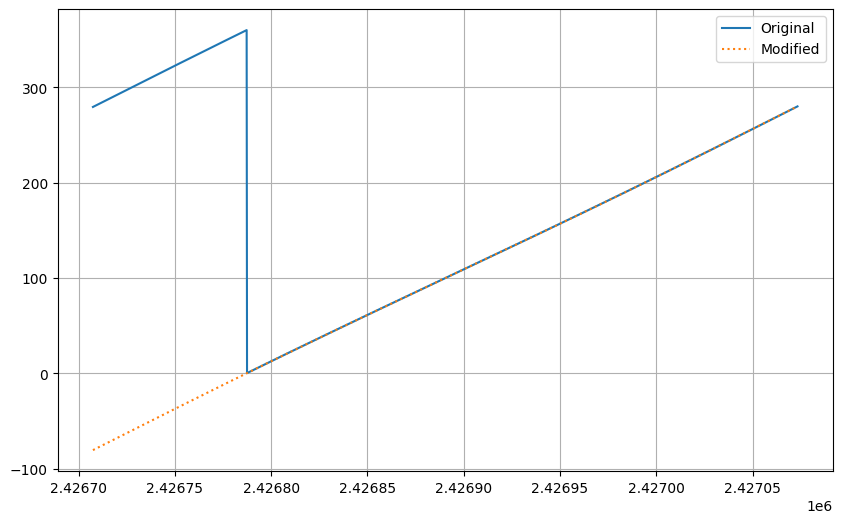

In [11]:
def modified_lon(year: int, jde: float) -> float:
  sjde, ejde = start_jde(year), end_jde(year)
  lon = common.sun_apparent_geocentric_coord(jde).lon

  apr_1st_jde = common.ut1_to_jde(year, 4, 1, 0.0)
  sub_360 = jde < apr_1st_jde and lon >= 250.0

  if sub_360:
    lon -= 360.0
  return lon

# Plot longitudes in 1932 (original data and modified data)
sjde_1932, ejde_1932 = start_jde(1932), end_jde(1932)

# Take JDEs from start of 1932 to end of 1932, with a step of 0.2
jdes_1932 = []

_jde = sjde_1932
while _jde < ejde_1932:
  jdes_1932.append(_jde)
  _jde += 0.2

# Compute original longitudes
lons_1932 = [common.sun_apparent_geocentric_coord(jde).lon for jde in jdes_1932]

# Compute modified longitudes
lons_1932_mod = [modified_lon(1932, jde) for jde in jdes_1932]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(jdes_1932, lons_1932, label='Original')
plt.plot(jdes_1932, lons_1932_mod, label='Modified', linestyle=':')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
from typing import Callable

def gen_f(year: int, expected_lon: float) -> Callable[[float], float]:
  '''
  @brief Generate a function `f` that calculates the difference between the calculated longitude and the expected longitude.
  @returns A function `f` whose signature is "f(jde: float) -> float".
           It calculates the longitude for `jde` and return its difference with the expected longitude `expected_lon`.
  @note `f` is defined on: `jde` in half-open interval [start_jde(year), end_jde(year)).
  '''
  def f(jde: float) -> float:
    lon = modified_lon(year, jde)
    return lon - expected_lon
  return f
  

def newton_method(f: Callable[[float], float], sjde: float, ejde: float) -> float:
  # Iteratively compute the root to let f(jde) = 0, where jde is in half-open interval [sjde, ejde).
  # Xn+1 = Xn - f(Xn) / f'(Xn)
  # f'(x) = (f(x+h) - f(x-h)) / (2*h), where h is a small number, usally [1e-8, 1e-5].
  # The initial guess is (sjde + ejde) / 2.

  jde = (sjde + ejde) / 2.0
  iters: int = 0
  while iters < 1000:
    delta = f(jde)
    if abs(delta) < 1.0e-10:
      break
    
    f_jde = f(jde)
    f_prime_jde = (f(jde + 1e-8) - f(jde - 1e-8)) / (2e-8)
    jde = jde - f_jde / f_prime_jde

    if jde < sjde:
      jde = sjde
    elif jde > ejde:
      jde = ejde - 1e-10

    iters += 1

  return jde
    

def find_roots(year: int, expected_lon: float) -> list[float]:
  '''
  Return the list of possible JDEs that satisfy:
  1. fall into the interval [start_jde(year), end_jde(year)), and
  2. the solar longitude at the JDE equals to the expected longitude.
  '''

  root_count = discriminant(year, expected_lon)
  print(f'year {year}, expected_lon {expected_lon}, root_count: {root_count}')

  slon, enlon = start_lon(year), end_lon(year)

  roots = []

  if root_count == 0:
    # No satisfying JDE.
    return roots

  f_list = []
  if slon <= expected_lon < 360.0:
    f_list.append(gen_f(year, expected_lon - 360.0))
  if 0.0 <= expected_lon < enlon:
    f_list.append(gen_f(year, expected_lon))

  for f in f_list:
    jde = newton_method(f, start_jde(year), end_jde(year))
    roots.append(jde)

  return roots

In [13]:
find_roots(1932, 279.75)

year 1932, expected_lon 279.75, root_count: 2


[2426707.882495547, 2427073.1162290075]

In [14]:
print(common.sun_apparent_geocentric_coord(2426707.882495547).lon)
print(common.sun_apparent_geocentric_coord(2427073.1162290075).lon)

279.74999999980906
279.74999999981816


In [15]:
find_roots(1901, 279.75)

year 1901, expected_lon 279.75, root_count: 0


[]

In [16]:
roots = find_roots(2024, 0.0)

print(f'roots: {roots}')
for root in roots:
  print(f'{root}: {common.sun_apparent_geocentric_coord(root).lon}')

year 2024, expected_lon 0.0, root_count: 1
roots: [2460389.6302362736]
2460389.6302362736: -2.1262771925101287e-10


In [17]:
roots = find_roots(2024, 279.5)

print(f'roots: {roots}')
for root in roots:
  print(f'{root}: {common.sun_apparent_geocentric_coord(root).lon}')

year 2024, expected_lon 279.5, root_count: 1
roots: [2460675.2124764244]
2460675.2124764244: 279.4999999998878


In [18]:
roots = find_roots(2024, 280)

print(f'roots: {roots}')
for root in roots:
  print(f'{root}: {common.sun_apparent_geocentric_coord(root).lon}')

year 2024, expected_lon 280, root_count: 1
roots: [2460675.7028490896]
2460675.7028490896: 279.99999999985334


In [19]:
roots = find_roots(2024, 280.5)

print(f'roots: {roots}')
for root in roots:
  print(f'{root}: {common.sun_apparent_geocentric_coord(root).lon}')

year 2024, expected_lon 280.5, root_count: 2
roots: [2460310.9532007626, 2460676.1932159397]
2460310.9532007626: 280.49999999995316
2460676.1932159397: 280.5000000001701
